In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub

import keras 
from keras.models import Sequential,Model
from keras.layers import LSTM,Bidirectional,Dense,Input,Embedding,TimeDistributed
from keras.callbacks import EarlyStopping, ModelCheckpoint

import nltk
import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from nltk.tokenize import word_tokenize
import numpy as np

In [3]:
from google.colab import drive,files
drive.mount("/content/drive")
dataM='/content/drive/My Drive/Colab Notebooks/MODELS/'
filepath = dataM+'BERT_CRF.ml'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!pip install tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [9]:
!pip install tf2crf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
from tf2crf import CRF 
from tf2crf import ModelWithCRFLoss

In [11]:
!cp -rf drive/MyDrive/job_20k.json /content/

In [12]:
import pandas as pd
import json
path_to_json = 'job_20k.json'
df  = pd.read_json(path_to_json,lines=True)
df.head().T

,0,1,2,3,4
clean_descrition,A technology services client of ours is lookin...,Job Title :Java Sr developerLocation: RemoteLo...,Mandatory Skills: Strong in Oracle database 19...,"Associate Scientist Thousand Oaks, CADescripti...","Growing fintech company looking for Mid Level,..."
organization_list,"[Swift, Strategic, Solutions, Inc]","[AQUA, Information, Systems,, Inc.]","[Softnet, Consulting, Inc]","[Apex, Systems]",[Jobot]
skill_list,"[NoSQL, Teradata, Netezza, Cosmos, DB, JSON, A...","[Java, JEE, J2EE]","[Oracle, database, 19c, Advanced, PL/SQL, prog...","[Biochemistry, Biology, Analytical, Systems]","[Developer, JavaScript, SQL, ASP, HTML, Archit..."
job_title_list,"[Bigdata, Engineer]","[Java, developer]","[Oracle, PL/SQL, Lead, Architect]","[Associate, Scientist]","[Software, Engineer]"


In [13]:
df['clean_descrition'] = df['clean_descrition'].str.replace(r'[^\w\s]+', ' ')
df['clean_descrition'] = df['clean_descrition'].apply(lambda x: ' '.join(x.split()[:128]))
df['clean_descrition'][1]

<ipython-input-13-42c4f31900d0>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['clean_descrition'] = df['clean_descrition'].str.replace(r'[^\w\s]+', ' ')


'Job Title Java Sr developerLocation RemoteLong TermSkills java jeShould have good understanding on the change management role and had depth knowledge on the change advisory board process CAB Good knowledge on the incident management Problem management Change Management Should have involved in the 3L level of activities i e root cause analysis environment analysis understanding the application architecture infrastructure architecture The resource should have very good understanding on the SDLC process Very good knowledge on the Java J2EE and have hands on experience in understanding the architecture of heterogeneous application Good communication skills and team handling abilities Should have worked on the onshore offshore model Should be flexible and having good attitude'

In [14]:
import pandas as pd
import json
path_to_json = 'job_20k.json'
df  = pd.read_json(path_to_json,lines=True)
df.head().T

,0,1,2,3,4
clean_descrition,A technology services client of ours is lookin...,Job Title :Java Sr developerLocation: RemoteLo...,Mandatory Skills: Strong in Oracle database 19...,"Associate Scientist Thousand Oaks, CADescripti...","Growing fintech company looking for Mid Level,..."
organization_list,"[Swift, Strategic, Solutions, Inc]","[AQUA, Information, Systems,, Inc.]","[Softnet, Consulting, Inc]","[Apex, Systems]",[Jobot]
skill_list,"[NoSQL, Teradata, Netezza, Cosmos, DB, JSON, A...","[Java, JEE, J2EE]","[Oracle, database, 19c, Advanced, PL/SQL, prog...","[Biochemistry, Biology, Analytical, Systems]","[Developer, JavaScript, SQL, ASP, HTML, Archit..."
job_title_list,"[Bigdata, Engineer]","[Java, developer]","[Oracle, PL/SQL, Lead, Architect]","[Associate, Scientist]","[Software, Engineer]"


In [15]:
jobs = list(df.clean_descrition)
def convert_to_list_then_dict(df_column= None, key_value=str):
    value_list = list(df_column)
    _ = list(set([item for value_list in value_list for item in value_list]))
    return dict.fromkeys(_, key_value)

org = convert_to_list_then_dict(df_column=df.organization_list, key_value='C')
skill = convert_to_list_then_dict(df_column=df.skill_list, key_value='S')
job = convert_to_list_then_dict(df_column=df.job_title_list, key_value='J')    

In [16]:
XTr= jobs[:1500]
XVal= jobs[1500:2000]
org_b = org
skills_b = skill
jobs_b = job

In [17]:
def make(X,org_b,skills_b,jobs_b):
  big=[]
  for sentence in X:
    token=word_tokenize(sentence)
    small=[]
    token_t=nltk.pos_tag(token)
    for f,s in token_t:
      tag='O'
      if f.lower() in org_b:
        tag=org_b[f.lower()]
      if f.lower() in skills_b:
        tag=skills_b[f.lower()]
      if f.lower() in jobs_b:
        tag=jobs_b[f.lower()]
      small.append((f,s,tag))
    big.append(small)
  return big
  
XTr_=make(XTr,org_b,skills_b,jobs_b)
XVal_=make(XVal,org_b,skills_b,jobs_b)

In [21]:
msgLen=128

def fixMsg(X):
  global msgLen
  Xc=[]
  for i in range(len(X)):
    if len(X[i])<msgLen:
      Xc.append(X[i].copy())
      while len(Xc[-1])<msgLen:
        Xc[-1].append(('UNK','UNK','UNK'))
    elif len(X[i])>msgLen:
      Xc.append(X[i].copy())
      temp=Xc[-1].copy()
      del Xc[-1]
      lb=0;chunk=msgLen
      while lb<len(temp):
        split=[]
        for j in range(lb,lb+chunk):
          if j<len(temp):
            split.append(temp[j])
          else:
            split.append(('UNK','UNK','UNK'))
        Xc.append(split)
        assert(len(split)==msgLen)
        lb+=chunk
  return Xc

XTr_t=fixMsg(XTr_)
XVal_t=fixMsg(XVal_)

In [22]:
for x in XTr_t:
  if len(x)!=msgLen:
    print(len(x))
print(XTr_t[0])
for x in XVal_t:
  assert(len(x)==msgLen)
print(XVal_t[0])

[('A', 'DT', 'J'), ('technology', 'NN', 'J'), ('services', 'NNS', 'J'), ('client', 'NN', 'J'), ('of', 'IN', 'J'), ('ours', 'NN', 'O'), ('is', 'VBZ', 'J'), ('looking', 'VBG', 'J'), ('For', 'IN', 'J'), ('Bigdata', 'NNP', 'S'), ('Engineer', 'NNP', 'J'), ('on', 'IN', 'J'), ('their', 'PRP$', 'S'), ('ongoing', 'JJ', 'O'), ('projects', 'NNS', 'J'), ('.', '.', 'J'), ('This', 'DT', 'S'), ('is', 'VBZ', 'J'), ('going', 'VBG', 'O'), ('to', 'TO', 'J'), ('be', 'VB', 'J'), ('an', 'DT', 'J'), ('Onsite', 'NNP', 'J'), ('position', 'NN', 'J'), ('.', '.', 'J'), ('Below', 'IN', 'J'), ('are', 'VBP', 'J'), ('the', 'DT', 'J'), ('required', 'JJ', 'J'), ('skills', 'NNS', 'J'), ('for', 'IN', 'J'), ('this', 'DT', 'S'), ('role', 'NN', 'J'), ('–Required', 'VBD', 'O'), ('Skills', 'NNS', 'J'), (':', ':', 'J'), ('Strong', 'JJ', 'J'), ('experience', 'NN', 'J'), ('building', 'NN', 'J'), ('and', 'CC', 'J'), ('optimizing', 'VBG', 'O'), ('‘', 'JJ', 'O'), ('big', 'JJ', 'S'), ('data', 'NNS', 'J'), ('’', 'NN', 'O'), ('pipelin

In [23]:
dict_={}
dict_1={}
token=1;token1=0
for x in XTr_t:
  for a,b,c in x:
    if a not in dict_:
      dict_[a]=token
      token=token+1
    if c not in dict_1:
      if c=='K':
        print(a,b,c)
      dict_1[c]=token1
      token1=token1+1
for x in XVal_t:
  for a,b,c in x:
    if a not in dict_:
      dict_[a]=token
      token=token+1
    if c not in dict_1:
      dict_1[c]=token1
      token1=token1+1
print('No of tokens words[{}] labels[{}]'.format(token,token1))

No of tokens words[38282] labels[5]


In [24]:
def bertCreate(X):
  temp=[]
  for sentence in X:
    s=''
    first=True
    for element in sentence:
      if first:
        first=False
        s=element[0]
      else:
        s=s+' '+element[0]
    temp.append(s)
  return np.array(temp)

In [25]:
XTr_fin=bertCreate(XTr_t)
XVal_fin=bertCreate(XVal_t)

yTr=np.array([[dict_1[element[2]] for element in sentence] for sentence in XTr_t])
yVal=np.array([[dict_1[element[2]] for element in sentence] for sentence in XVal_t])

In [26]:
import tensorflow_text as text
preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3")

In [27]:
text_preprocessed = preprocessor(np.array(XTr_fin[:2]))

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_mask', 'input_word_ids', 'input_type_ids']
Shape      : (2, 128)
Word Ids   : [  101   138  2815  1826  7230  1104 17079  1110  1702  1370  2562 27922]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [28]:
# https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/4
# https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3

bert_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/4', trainable=False)

In [29]:
input=Input(shape=(), dtype=tf.string)
model0=preprocessor(input)
seq_op=bert_layer(model0)['sequence_output']
model0=Model(input,seq_op)
model0.summary()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['input_2[0][0]']                
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [30]:
XTr_fin=model0.predict(XTr_fin)
XVal_fin=model0.predict(XVal_fin)

55/55 [==============================] - 18s 324ms/step


In [31]:
print(XTr_fin.shape,XVal_fin.shape,type(XTr_fin),type(XVal_fin))

(5228, 128, 768) (1736, 128, 768) <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [32]:
print(yTr.shape,yVal.shape,type(yTr),type(yVal))

(5228, 128) (1736, 128) <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [33]:
input=Input(shape=(XTr_fin.shape[1],XTr_fin.shape[2]))
output=CRF(units=token1)(input)
mo=Model(input,output)
mo.summary()

model1=ModelWithCRFLoss(mo,sparse_target=True)
model1.compile(optimizer ='rmsprop')

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 768)]        0         
                                                                 
 crf (CRF)                   ((None, 128),             3870      
                              (None, 128, 5),                    
                              (None,),                           
                              (5, 5))                            
                                                                 
Total params: 3,870
Trainable params: 3,870
Non-trainable params: 0
_________________________________________________________________


In [43]:
es = EarlyStopping(monitor = "val_loss_val", mode = "min", verbose = True, restore_best_weights=True, patience = 1)
cp = ModelCheckpoint(filepath,monitor="val_loss_val",mode = "min",verbose=True,save_best_only=True)

history = model1.fit(XTr_fin,yTr,validation_data=[XVal_fin,yVal],epochs=15,batch_size=100,callbacks=[cp,es])

Epoch 1/15
53/53 [==============================] - ETA: 0s - loss: 116.9780 - accuracy: 0.5925
Epoch 1: val_loss_val improved from inf to 115.52097, saving model to /content/drive/My Drive/Colab Notebooks/MODELS/BERT_CRF.ml


53/53 [==============================] - 25s 387ms/step - loss: 116.9780 - accuracy: 0.5925 - val_loss_val: 115.5210 - val_val_accuracy: 0.5852
Epoch 2/15
53/53 [==============================] - ETA: 0s - loss: 116.1730 - accuracy: 0.5918
Epoch 2: val_loss_val improved from 115.52097 to 114.59867, saving model to /content/drive/My Drive/Colab Notebooks/MODELS/BERT_CRF.ml


53/53 [==============================] - 19s 365ms/step - loss: 116.1730 - accuracy: 0.5918 - val_loss_val: 114.5987 - val_val_accuracy: 0.5975
Epoch 3/15
53/53 [==============================] - ETA: 0s - loss: 115.2790 - accuracy: 0.5926
Epoch 3: val_loss_val improved from 114.59867 to 113.92691, saving model to /content/drive/My Drive/Colab Notebooks/MODELS/BERT_CRF.ml


53/53 [==============================] - 19s 356ms/step - loss: 115.2790 - accuracy: 0.5926 - val_loss_val: 113.9269 - val_val_accuracy: 0.5970
Epoch 4/15
53/53 [==============================] - ETA: 0s - loss: 114.8014 - accuracy: 0.5930
Epoch 4: val_loss_val improved from 113.92691 to 113.44425, saving model to /content/drive/My Drive/Colab Notebooks/MODELS/BERT_CRF.ml


53/53 [==============================] - 21s 390ms/step - loss: 114.8014 - accuracy: 0.5930 - val_loss_val: 113.4443 - val_val_accuracy: 0.5873
Epoch 5/15
53/53 [==============================] - ETA: 0s - loss: 114.2078 - accuracy: 0.5938
Epoch 5: val_loss_val improved from 113.44425 to 112.99226, saving model to /content/drive/My Drive/Colab Notebooks/MODELS/BERT_CRF.ml


53/53 [==============================] - 19s 356ms/step - loss: 114.2078 - accuracy: 0.5938 - val_loss_val: 112.9923 - val_val_accuracy: 0.5901
Epoch 6/15
53/53 [==============================] - ETA: 0s - loss: 113.4127 - accuracy: 0.5934
Epoch 6: val_loss_val improved from 112.99226 to 112.13487, saving model to /content/drive/My Drive/Colab Notebooks/MODELS/BERT_CRF.ml


53/53 [==============================] - 23s 434ms/step - loss: 113.4127 - accuracy: 0.5934 - val_loss_val: 112.1349 - val_val_accuracy: 0.6013
Epoch 7/15
53/53 [==============================] - ETA: 0s - loss: 112.7864 - accuracy: 0.5938
Epoch 7: val_loss_val improved from 112.13487 to 111.76264, saving model to /content/drive/My Drive/Colab Notebooks/MODELS/BERT_CRF.ml


53/53 [==============================] - 19s 356ms/step - loss: 112.7864 - accuracy: 0.5938 - val_loss_val: 111.7626 - val_val_accuracy: 0.5878
Epoch 8/15
53/53 [==============================] - ETA: 0s - loss: 112.3079 - accuracy: 0.5949
Epoch 8: val_loss_val improved from 111.76264 to 111.25028, saving model to /content/drive/My Drive/Colab Notebooks/MODELS/BERT_CRF.ml


53/53 [==============================] - 19s 360ms/step - loss: 112.3079 - accuracy: 0.5949 - val_loss_val: 111.2503 - val_val_accuracy: 0.6072
Epoch 9/15
53/53 [==============================] - ETA: 0s - loss: 111.8453 - accuracy: 0.5951
Epoch 9: val_loss_val improved from 111.25028 to 111.23426, saving model to /content/drive/My Drive/Colab Notebooks/MODELS/BERT_CRF.ml


53/53 [==============================] - 20s 377ms/step - loss: 111.8453 - accuracy: 0.5951 - val_loss_val: 111.2343 - val_val_accuracy: 0.5808
Epoch 10/15
53/53 [==============================] - ETA: 0s - loss: 111.2215 - accuracy: 0.5950
Epoch 10: val_loss_val improved from 111.23426 to 110.54550, saving model to /content/drive/My Drive/Colab Notebooks/MODELS/BERT_CRF.ml


53/53 [==============================] - 19s 357ms/step - loss: 111.2215 - accuracy: 0.5950 - val_loss_val: 110.5455 - val_val_accuracy: 0.5946
Epoch 11/15
53/53 [==============================] - ETA: 0s - loss: 111.0387 - accuracy: 0.5946
Epoch 11: val_loss_val improved from 110.54550 to 110.08775, saving model to /content/drive/My Drive/Colab Notebooks/MODELS/BERT_CRF.ml


53/53 [==============================] - 19s 359ms/step - loss: 111.0387 - accuracy: 0.5946 - val_loss_val: 110.0878 - val_val_accuracy: 0.5824
Epoch 12/15
53/53 [==============================] - ETA: 0s - loss: 110.5122 - accuracy: 0.5948
Epoch 12: val_loss_val improved from 110.08775 to 109.52505, saving model to /content/drive/My Drive/Colab Notebooks/MODELS/BERT_CRF.ml


53/53 [==============================] - 19s 360ms/step - loss: 110.5122 - accuracy: 0.5948 - val_loss_val: 109.5251 - val_val_accuracy: 0.5919
Epoch 13/15
53/53 [==============================] - ETA: 0s - loss: 110.1684 - accuracy: 0.5946
Epoch 13: val_loss_val improved from 109.52505 to 109.10497, saving model to /content/drive/My Drive/Colab Notebooks/MODELS/BERT_CRF.ml


53/53 [==============================] - 19s 357ms/step - loss: 110.1684 - accuracy: 0.5946 - val_loss_val: 109.1050 - val_val_accuracy: 0.5994
Epoch 14/15
53/53 [==============================] - ETA: 0s - loss: 109.7811 - accuracy: 0.5935
Epoch 14: val_loss_val improved from 109.10497 to 108.96278, saving model to /content/drive/My Drive/Colab Notebooks/MODELS/BERT_CRF.ml


53/53 [==============================] - 19s 367ms/step - loss: 109.7811 - accuracy: 0.5935 - val_loss_val: 108.9628 - val_val_accuracy: 0.5905
Epoch 15/15
53/53 [==============================] - ETA: 0s - loss: 109.4867 - accuracy: 0.5928
Epoch 15: val_loss_val did not improve from 108.96278
Restoring model weights from the end of the best epoch: 14.
53/53 [==============================] - 19s 348ms/step - loss: 109.4867 - accuracy: 0.5928 - val_loss_val: 109.0527 - val_val_accuracy: 0.6018
Epoch 15: early stopping


In [44]:
model1.load_weights(filepath)

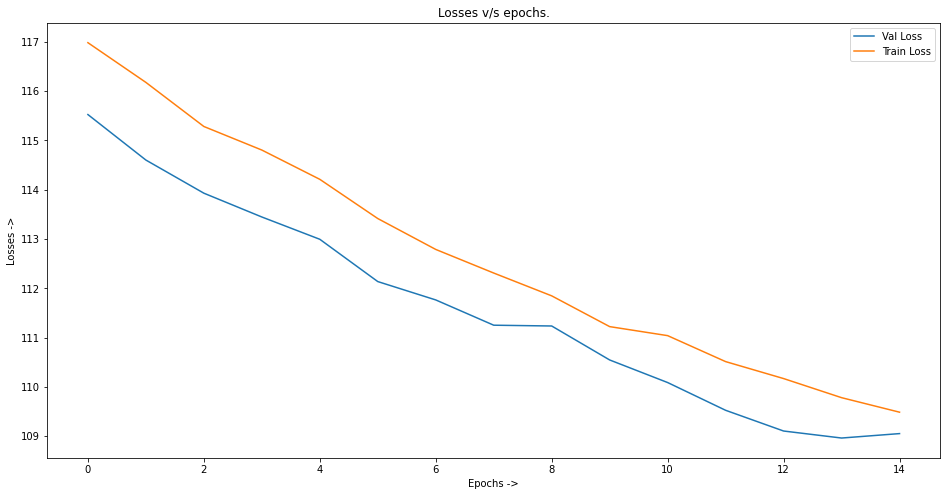

In [45]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (16,8)
plt.plot(history.history['val_loss_val'])
plt.plot(history.history['loss'])
plt.xlabel('Epochs ->')
plt.ylabel('Losses ->')
plt.title('Losses v/s epochs.')
plt.legend(['Val Loss','Train Loss'])
plt.show()

In [46]:
dict_1R={}
for k,v in dict_1.items():
  dict_1R[v]=k

In [47]:
labels_=model1.predict(XVal_fin)
i=0 # i-th example from val dataset.
cnt=0
print()
for x in XVal_[0]:
  print('{} {}'.format(x[0],dict_1R[labels_[i][cnt]]))
  cnt+=1
  if cnt>10:
    break

55/55 [==============================] - 4s 77ms/step

Title J
: J
ServiceNow J
Developer J
Duration J
: J
12-24 J
month J
contract J
or J
CTH J


In [49]:
dict_1

{'J': 0, 'O': 1, 'S': 2, 'UNK': 3, 'C': 4}

In [50]:
!pip install sklearn-crfsuite

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [51]:
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

def labelIt(yVal):
  yVal_lis=[]
  for y1 in yVal:
    temp=[]
    for y2 in y1:
      temp.append(dict_1R[y2])
    yVal_lis.append(temp)
  return yVal_lis 

yVal_=labelIt(yVal)
yPred_=labelIt(labels_)
labls=['C','J','S','O','UNK']
metrics.flat_f1_score(yVal_,yPred_,average='weighted',labels=labls)

0.5012617074997893

In [52]:
pip install -U 'scikit-learn<0.24'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [53]:
print(metrics.flat_classification_report(yVal_,yPred_,labels=labls,digits=3))

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=['C', 'J', 'S', 'O', 'UNK'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           C      0.000     0.000     0.000        94
           J      0.581     0.870     0.697    109393
           S      0.268     0.026     0.048     41666
           O      0.341     0.105     0.161     37973
         UNK      0.727     0.936     0.818     33082

    accuracy                          0.591    222208
   macro avg      0.383     0.387     0.345    222208
weighted avg      0.503     0.591     0.501    222208

